In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



In [2]:
# 包含所有患者目录的根目录
#INPUT_FOLDER = 'C:/Users/Sonny/Desktop/materials/Red_2/'
INPUT_FOLDER = 'D:\Software Project\Red_2'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

def load_scan(path):
    slices = [pydicom.read_file(path +'/' + s, force= True) for s in os.listdir(path)]
    for i in range(len(slices)):
        try:
            slices[i].ImagePositionPatient
        except:
            slices.pop(i)
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices
    
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # 转换为int16，int16是ok的，因为所有的数值都应该 <32k
    image = image.astype(np.int16)

    # 设置边界外的元素为0
    image[image == -2000] = 0

    # 转换为HU单位
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)


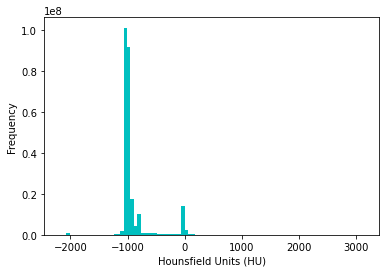

In [3]:
first_patient = load_scan(INPUT_FOLDER)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=90, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


mid slices  481


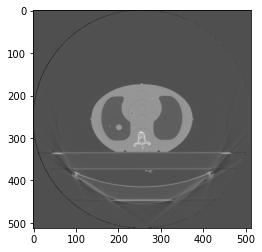

(512, 512)


In [4]:
def printSlide(patients):
    mid_slides = int(len(patients)/2)
    first_patient_pixel = get_pixels_hu(patients)
    # 显示一个中间位置的切片
    print("mid slices ",mid_slides)
    plt.imshow(first_patient_pixel[mid_slides], cmap=plt.cm.gray)
    plt.show()
    print(first_patient_pixel[mid_slides].shape)
    return first_patient_pixel[mid_slides]

mid_slide = printSlide(first_patient)

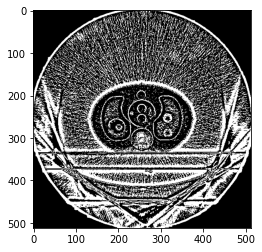

In [5]:
def adaptiveThreshold(slide):
    ##### tmp = first_patient[mid_slides]
    temp = slide
    #tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
    #print(type(tmp), tmp)
    #print(type(temp), temp.shape)
    #print(temp)
    gray_src = np.uint8(temp)
    gray_src = cv2.bitwise_not(gray_src)
    #print(gray_src)
    res = cv2.adaptiveThreshold(gray_src,125, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,-2)
    plt.imshow(res, cmap=plt.cm.gray)
    plt.show()
    return res

grayMap = adaptiveThreshold(mid_slide)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


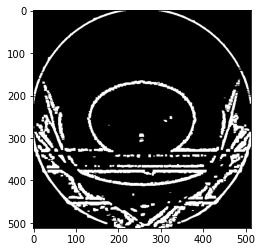

In [6]:
def morphology(map):
    hline = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5), (-1, -1))
    vline = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1), (-1, -1))
    temp = cv2.erode(map, hline)
    dst = cv2.dilate(temp, hline)
    dst = cv2.morphologyEx(map, cv2.MORPH_OPEN, hline)
    dst = cv2.morphologyEx(dst, cv2.MORPH_OPEN, vline)
    #dst = cv2.bitwise_not(dst)
    print(dst)
    plt.imshow(dst, cmap=plt.cm.gray)
    plt.show()
    return dst
    
morMap = morphology(grayMap)

In [7]:
def findCouch(map):
    rows = map.shape[0]
    cols = map.shape[1]
    for i in range(rows):
        count = 0
        for j in range(cols):
            if(map[i][j] > 0):
                count = count + 1

        if(count > 126):
            print(i)
            return i
    print("couch did not find")
    return rows

findCouch(morMap)

324


324

In [17]:
def CouchRemove(patients):
    mid_slides = int(len(patients)/2)
    first_patient_pixel = get_pixels_hu(patients)
    
    grayMap = adaptiveThreshold(first_patient_pixel[mid_slides])
    morMap = morphology(grayMap)
    couchPos = findCouch(morMap)
    removedSet = first_patient_pixel.copy()
    for i in range(len(first_patient_pixel)):
        tmp = first_patient_pixel[i]
        rows = tmp.shape[0]
        cols = tmp.shape[1]
        for r in range(couchPos, rows):
            for c in range(cols):
                removedSet[i][r][c] = -1024
    return removedSet

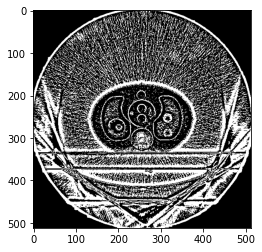

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


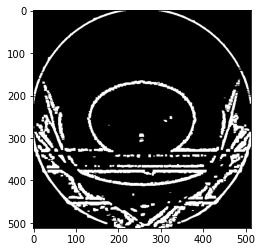

324


In [19]:
removed = CouchRemove(first_patient)

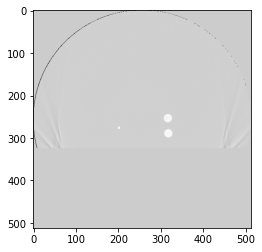

In [22]:
plt.imshow(removed[10], cmap=plt.cm.gray)
plt.show()